In [2]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
## function for stats summary
## para: 'MODIS'or 'CGLS'
## directory: location for storing csv file, like "D:\\vegetation\\gee\\notebook"
## dominantEZ: 'boreal','tropical','temperate'
## countthres: 0.9
## waterfrac: 0.1, etc.
##xmin, xmax, ymin, ymax: axis limits
#def calStas(para, inputdir, dominantLC, dominantEZ, countthres):
def calStas2(biopara, sensor, inputdir, dominantEZ, waterfrac, countthres, xmin, xmax, ymin, ymax):

    #############read csv file into list of dataframe
    if biopara=='LAI' and sensor=='MODIS':
        scale=10.0
    elif biopara=='FAPAR' and sensor=='MODIS':
        scale=100
        print ('in FAPAR MODIS')
    elif biopara=='LAI' and sensor=='CGLS':
        scale=30
    elif biopara=='FAPAR' and sensor=='CGLS':
        scale=250
        print ('in FAPAR CGLS')
    elif biopara=='FCOVER' and sensor=='CGLS':
        scale=250
        print ('in FCOVER CGLS')
    else:
        print ('Choose a parameter')
        
    parameter=sensor+".csv"
    df_list=[]
    for filename in os.listdir(inputdir):
        if filename.find(parameter)!=-1: 
            #print(filename)       
            df=pd.read_csv (inputdir+"\\"+filename, index_col=0)
            df_list.append(df)
    print ('The number of csv files:',len(df_list))
    #################### create a new dataframe based on condtions applied####
    if dominantEZ=='boreal':
        lc = [41.0]    
    elif dominantEZ== 'tropical':
        lc = [11.0, 12.0, 13.0, 21.0, 22.0]
    elif dominantEZ== 'temperate':
        lc = [31.0,32.0]
    else: 
        print ('please choose a EZ type: boreal, tropical, temperate')
        return

    newdf_list=[]
    for i in range (0, len(df_list)):    
        mask=df_list[i]['S2'+sensor+'_EZ'].isin(lc) & (df_list[i]['S2'+sensor+'_WaterFraction']<waterfrac) & (df_list[i]['S2'+sensor+'_'+biopara+'COUNT'] >5625*countthres)
        tempdf=df_list[i].loc[mask]
        newdf_list.append(tempdf)
   # print (len(newdf_list))
    ## generate a new df from different tiles
    newdf=pd.concat(newdf_list)
    newdf['S2'+biopara]=newdf['S2'+sensor+'_'+biopara]/1000  ###
    newdf[sensor+biopara]=newdf[sensor+'_'+biopara]/scale
   
    ### sampling points 
    if len(newdf)>50000:
        newdfs=newdf.sample(n = 50000)
    elif len(newdf)==0:
        print ('no sampling points')
        return
    else:
        newdfs=newdf
    print ('Sample points for plotting:',len(newdfs))
    ##########################plot################# 
   ### convert one column to numpy array
    x=newdfs[sensor+biopara].to_numpy()
    y=newdfs['S2'+biopara].to_numpy()
     ######Computes the Theil-Sen estimator for a set of points (x, y)###
    res=stats.theilslopes(x,y,0.90 )
    print ('Theil-Sen estimator:', res)
    ##Calculate a linear least-squares regression for two sets of measurements.
    lsq_res=stats.linregress(x,y)
    print ('linear least-squares estimator:', lsq_res)
    fig,ax = plt.subplots() 
#     plt.axis('equal')
#     ax.axis('equal')
    ax.set_aspect('equal', 'box')
#     ax.set_xlim([0.2,4])
#     ax.set_ylim([0.2,4])
    #ax.set_aspect('equal')  
    counts, xedges, yedges, im = ax.hist2d(newdf[sensor+biopara],newdf['S2'+biopara], bins=100)   
    fig.colorbar(im, ax=ax)
    ax.set_title('2D Histogram',fontsize=14)
    ax.set_xlabel(sensor,fontsize=14)   
    ax.set_ylabel('SL2P',fontsize=14)
    ax.plot(x, res[1]+res[0]*x,'y-') ## plot for Theil-Sen estimator  
    ax.plot(x, lsq_res[1]+lsq_res[0]*x,'w--',dashes=(2, 5)) # plot for linear least-squares regression
    
#     ax.set_aspect('equal', 'box')
# #     ax.set_aspect('equal')
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    fig.savefig(inputdir+'\\'+biopara+'_'+sensor+'_'+dominantEZ+'_fig.jpg')
    fig.savefig(inputdir+'\\'+biopara+'_'+sensor+'_'+dominantEZ+'_fig.svg')
    
    newdf[sensor+'S2_'+'diff']=newdf[sensor+'_'+biopara]/scale-newdf['S2'+sensor+'_'+biopara]/1000   ###
        
    bias=newdf[sensor+'S2_'+'diff'].mean()  ### accuracy, bias
    precision=((newdf[sensor+'S2_'+'diff']-bias)** 2).mean() **.5 ### precision
    rmse=((newdf[sensor+'S2_'+'diff']) ** 2).mean() ** .5   ### uncertainty
     #print (tile, CGLS_ezones, CGLS_num, CGLS_needle, CGLS_broadleaf, CGLS_mixed, CGLS_bias, CGLS_precision, CGLS_rmse)
    key1='S2'+sensor+'_'+biopara+'_P'
    key2='S2'+sensor+'_'+biopara+'_U'
    key3='S2'+sensor+'_'+biopara+'_A'
    row= [{'dominantEZ':dominantEZ,key1:precision,key2:rmse,key3:bias}]    
    ## add each tile stats to tile dataframe
    ez_df=pd.DataFrame(row)##, ignore_index=True) 
    ez_df.to_csv(inputdir+'\\'+biopara+'_'+'S2'+sensor+'_'+dominantEZ+'.csv')

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (1.7130542935131172, -0.7134843235525921, 1.6965654293951271, 1.7295332858827233)
linear least-squares estimator: LinregressResult(slope=0.20512618731697274, intercept=1.3102291239291608, rvalue=0.5761664703691629, pvalue=0.0, stderr=0.0013013541707912225)


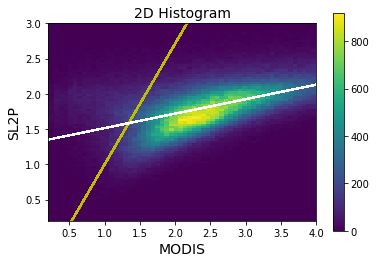

In [4]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_Bel", 'boreal', 0.1, 0.9,0.2,4, 0.2,3) 

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (1.9451843005763574, -1.0021223991364931, 1.9191332055915995, 1.9712336049884758)
linear least-squares estimator: LinregressResult(slope=0.11771898475251055, intercept=1.9134737081068132, rvalue=0.43831011014570087, pvalue=0.0, stderr=0.0010796009886141465)


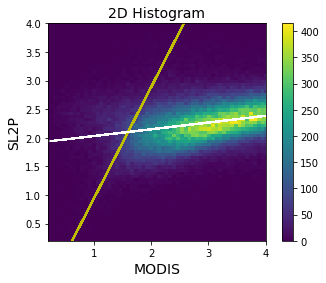

In [5]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_Bel", 'tropical', 0.1, 0.9,0.2,4, 0.2,4) 

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (1.4020358016829502, 0.024628601670351635, 1.3856891543829517, 1.4183155747893252)
linear least-squares estimator: LinregressResult(slope=0.20959680930739014, intercept=1.9436699874893215, rvalue=0.5146320724213072, pvalue=0.0, stderr=0.0015617108035896451)


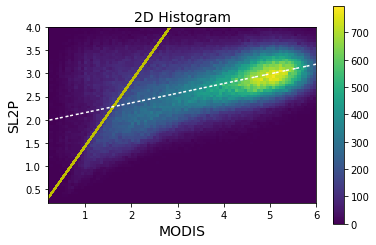

In [6]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_Bel", 'temperate', 0.1, 0.9,0.2,6, 0.2,4) 

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (2.26246914452749, -1.4840188911624272, 2.2520756757920877, 2.272865829388501)
linear least-squares estimator: LinregressResult(slope=0.32757990110014135, intercept=0.9050981287646231, rvalue=0.8491727157000559, pvalue=0.0, stderr=0.0009111158333887153)


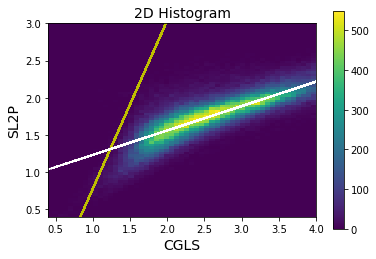

In [7]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_Bel", 'boreal', 0.1, 0.9, 0.4, 4, 0.4, 3) 

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (2.197318746848646, -1.114591137980244, 2.185801411834895, 2.208846294988047)
linear least-squares estimator: LinregressResult(slope=0.2688701156399709, intercept=1.25260481398674, rvalue=0.7343633985840811, pvalue=0.0, stderr=0.001111396954247097)


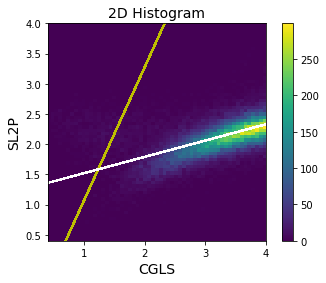

In [8]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_Bel", 'tropical', 0.1, 0.9, 0.4,4, 0.4,4) 

The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (1.6399595779620508, 0.5766641973467319, 1.6294176638447369, 1.6504821905742786)
linear least-squares estimator: LinregressResult(slope=0.34012923107954296, intercept=1.119293102022681, rvalue=0.7434448843084731, pvalue=0.0, stderr=0.0013684007844945718)


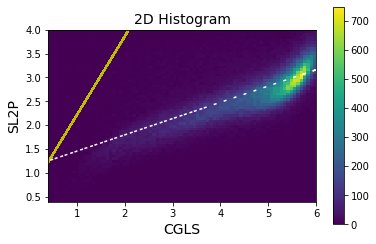

In [9]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_Bel", 'temperate', 0.1, 0.9, 0.4,6, 0.4,4)

in FAPAR MODIS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.8253505701454942, 0.33711859267134187, 0.8159041001647203, 0.8347937495256725)
linear least-squares estimator: LinregressResult(slope=0.256084531668579, intercept=0.2751166059943598, rvalue=0.4349369935311096, pvalue=0.0, stderr=0.002371076336330478)


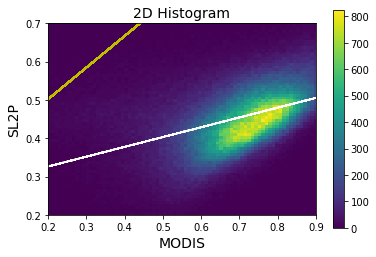

In [10]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_Bel", 'boreal', 0.1, 0.9, 0.2,0.9, 0.2,0.7) 

in FAPAR MODIS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.5140994852541844, 0.4603102128608404, 0.5063356170316031, 0.521854693086874)
linear least-squares estimator: LinregressResult(slope=0.39792832087133634, intercept=0.3379819892213873, rvalue=0.48115770021149773, pvalue=0.0, stderr=0.003242346546590379)


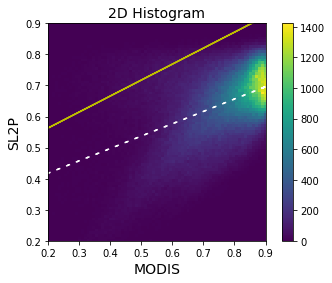

In [11]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_Bel", 'temperate', 0.1, 0.9, 0.2,0.9, 0.2,0.9) 

in FAPAR MODIS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.6316348411925654, 0.37925958445853064, 0.6187996133717278, 0.6444470005124764)
linear least-squares estimator: LinregressResult(slope=0.1822502831682784, intercept=0.4401521448637592, rvalue=0.3303644379343688, pvalue=0.0, stderr=0.00232864439259138)


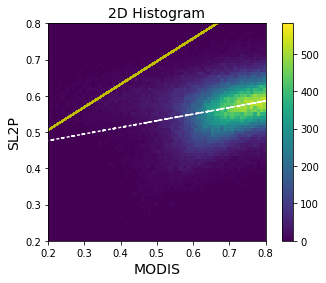

In [12]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_Bel", 'tropical', 0.1, 0.9, 0.2,0.8, 0.2,0.8) 

in FAPAR CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.9967387478045637, 0.2209492488372915, 0.9921043716358047, 1.0013730823989293)
linear least-squares estimator: LinregressResult(slope=0.7170306075073452, intercept=-0.030033470478732394, rvalue=0.8309555881046014, pvalue=0.0, stderr=0.002146954695624548)


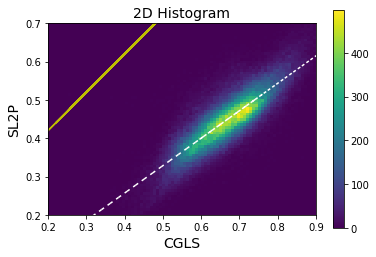

In [32]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_Bel", 'boreal', 0.1, 0.9, 0.2,0.9, 0.2,0.7)

in FAPAR CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.776174913960455, 0.32244462878109037, 0.7717695528093068, 0.7805767063008121)
linear least-squares estimator: LinregressResult(slope=0.8155944583824736, intercept=-0.02047446975246181, rvalue=0.8424234549835309, pvalue=0.0, stderr=0.0023329638750026116)


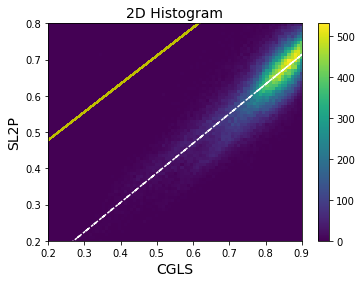

In [33]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_Bel", 'temperate', 0.1, 0.9, 0.2,0.9, 0.2,0.8) 

in FAPAR CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.884114359496402, 0.24814731911364774, 0.8780906184831847, 0.8901351306895858)
linear least-squares estimator: LinregressResult(slope=0.5414734260439725, intercept=0.16254442886499532, rvalue=0.6926803431359829, pvalue=0.0, stderr=0.0025214514670276094)


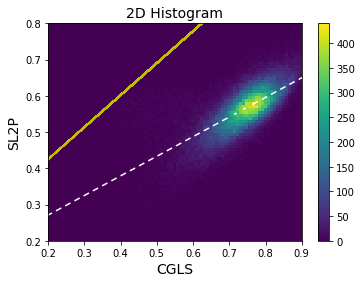

In [34]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_Bel", 'tropical', 0.1, 0.9, 0.2,0.9, 0.2,0.8) 

in FCOVER CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (1.273107682986375, 0.02837881752083804, 1.2685767278917304, 1.2776340472933185)
linear least-squares estimator: LinregressResult(slope=0.6491038857332424, intercept=0.054526774838535685, rvalue=0.9043855191239318, pvalue=0.0, stderr=0.0013696940334512863)


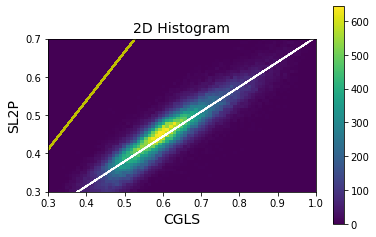

In [13]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_Bel", 'boreal', 0.1, 0.9, 0.3,1, 0.3,0.7) 

in FCOVER CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.7915869491218608, 0.36257488966258744, 0.7870312154723861, 0.7961352039211045)
linear least-squares estimator: LinregressResult(slope=0.8073414040669555, intercept=-0.0509319939696794, rvalue=0.8439767211276968, pvalue=0.0, stderr=0.0022946838488819747)


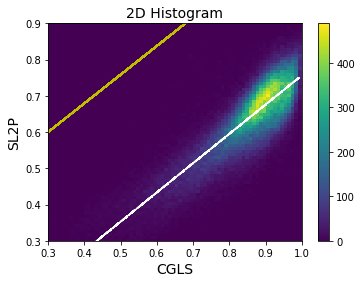

In [14]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_Bel", 'temperate', 0.1, 0.9, 0.3,1, 0.3,0.9) 

in FCOVER CGLS
The number of csv files: 35
Sample points for plotting: 50000
Theil-Sen estimator: (0.8929707431991778, 0.2851385780617741, 0.8858422854920388, 0.9000940903130071)
linear least-squares estimator: LinregressResult(slope=0.5329137885313997, intercept=0.1441690765726219, rvalue=0.6883223581335237, pvalue=0.0, stderr=0.002511708730492679)


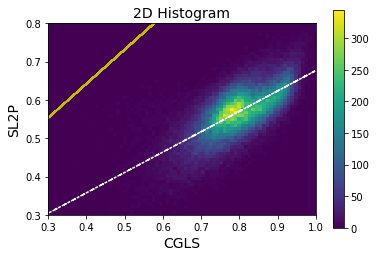

In [15]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_Bel", 'tropical', 0.1, 0.9, 0.3,1, 0.3,0.8) 

In [ ]:
# calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_Bel", 'tropical', 0.1, 0.9) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (1.5210964482799882, -0.5992747171785493, 1.5077807819029183, 1.534405728280191)
linear least-squares estimator: LinregressResult(slope=0.26436216864695145, intercept=1.3022742778575331, rvalue=0.6211550371724841, pvalue=0.0, stderr=0.0014916468384331921)


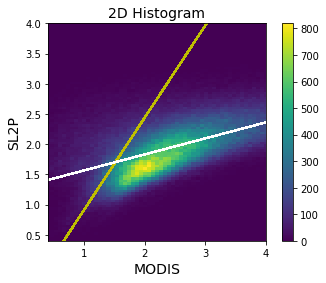

In [16]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_CCRS", 'boreal', 0.1, 0.9, 0.4,4, 0.4,4) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (1.1350647669638372, 1.3770278328630274, 1.118315572264132, 1.1517923964046934)
linear least-squares estimator: LinregressResult(slope=0.18822100208193213, intercept=1.9685049775604835, rvalue=0.4610549617567752, pvalue=0.0, stderr=0.0016201102911679469)


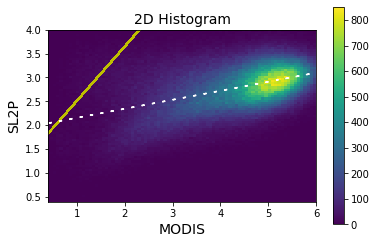

In [17]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_CCRS", 'temperate', 0.1, 0.9, 0.4,6, 0.4,4) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (1.9534797979829204, -1.0632501762728523, 1.93080901625669, 1.9761083901471406)
linear least-squares estimator: LinregressResult(slope=0.14352512444300672, intercept=1.8824797344000062, rvalue=0.49833077062222686, pvalue=0.0, stderr=0.0011167256527090368)


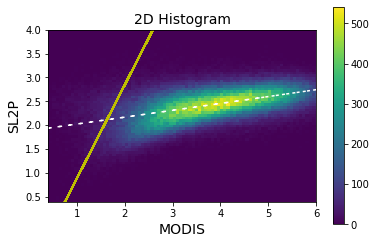

In [18]:
calStas2('LAI','MODIS', "D:\\vegetation\\gee\\LAI_CCRS", 'tropical', 0.1, 0.9,0.4,6, 0.4,4) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (2.2414266336519333, -1.6355560467799917, 2.231167980991947, 2.25168738685032)
linear least-squares estimator: LinregressResult(slope=0.342727704194585, intercept=0.9549474992007901, rvalue=0.8698794469087896, pvalue=0.0, stderr=0.0008691476901919466)


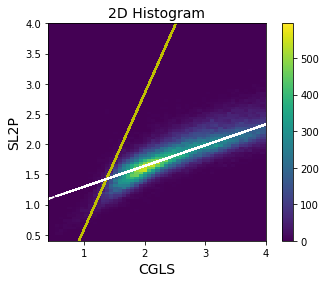

In [19]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_CCRS", 'boreal', 0.1, 0.9, 0.4,4, 0.4,4) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (1.5972468829859787, 0.7874436040989838, 1.5881737294988474, 1.6063204494273888)
linear least-squares estimator: LinregressResult(slope=0.4078306357383908, intercept=0.7316544326386123, rvalue=0.829700293295505, pvalue=0.0, stderr=0.0012270979073300582)


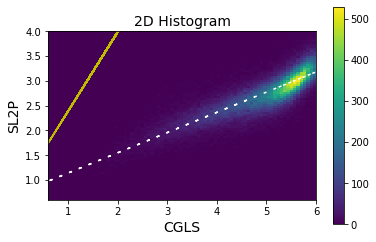

In [20]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_CCRS", 'temperate', 0.1, 0.9,0.6,6, 0.6,4) 

The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (2.192754465404522, -1.1028783570132674, 2.1828988216710363, 2.202606611613711)
linear least-squares estimator: LinregressResult(slope=0.33117432525535334, intercept=1.0383803790718822, rvalue=0.8333399864962551, pvalue=0.0, stderr=0.0009824157909652357)


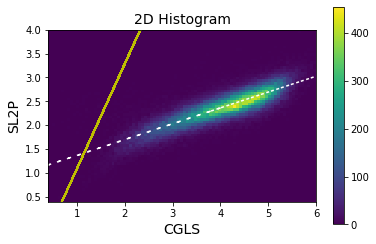

In [31]:
calStas2('LAI','CGLS', "D:\\vegetation\\gee\\LAI_CCRS", 'tropical', 0.1, 0.9,0.4,6, 0.4,4) 

in FAPAR MODIS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.363561729081902, 0.610780581956909, 0.3565930330357407, 0.3705347645926074)
linear least-squares estimator: LinregressResult(slope=0.33780679467182123, intercept=0.3765790239171285, rvalue=0.4095299952476615, pvalue=0.0, stderr=0.0033654444759214893)


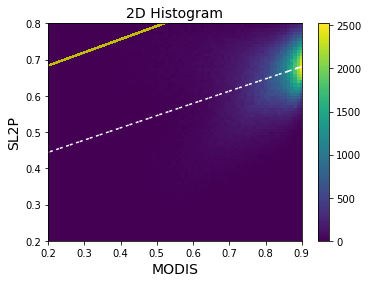

In [22]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'temperate', 0.1, 0.9,0.2,0.9, 0.2,0.8) 

in FAPAR MODIS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.7606103990411427, 0.3228797763292328, 0.7516427987853069, 0.7695737487674955)
linear least-squares estimator: LinregressResult(slope=0.29656732611844977, intercept=0.2839393908167429, rvalue=0.45493255821175715, pvalue=0.0, stderr=0.00259625005200421)


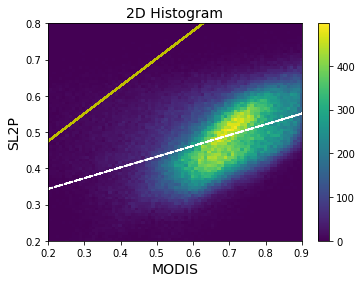

In [23]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'boreal', 0.1, 0.9, 0.2,0.9, 0.2,0.8) 

in FAPAR MODIS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.6755294259887255, 0.35122006369209363, 0.6630209556264534, 0.6880259047631848)
linear least-squares estimator: LinregressResult(slope=0.20248942962393024, intercept=0.43791786318269466, rvalue=0.365884882597709, pvalue=0.0, stderr=0.002303417582881587)


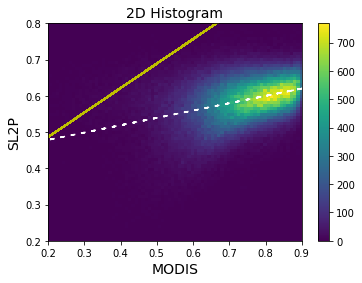

In [24]:
calStas2('FAPAR','MODIS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'tropical', 0.1, 0.9, 0.2,0.9, 0.2,0.8) 

in FAPAR CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.6716920358343008, 0.4121546188267163, 0.6671517036052045, 0.6762298292539116)
linear least-squares estimator: LinregressResult(slope=0.8132556617148108, intercept=-0.030004887229809207, rvalue=0.7826801042361544, pvalue=0.0, stderr=0.0028923639368831147)


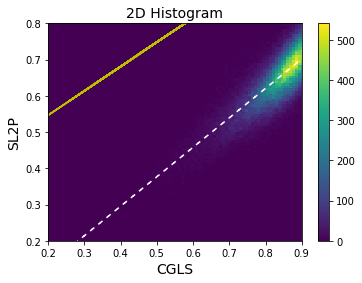

In [25]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'temperate', 0.1, 0.9, 0.2,0.9, 0.2,0.8) 

in FAPAR CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.9623651625375498, 0.21616740989047123, 0.9574270591147163, 0.9673013954145528)
linear least-squares estimator: LinregressResult(slope=0.7096619017585888, intercept=-0.0002742668218781996, rvalue=0.8160252493036416, pvalue=0.0, stderr=0.0022480793200735736)


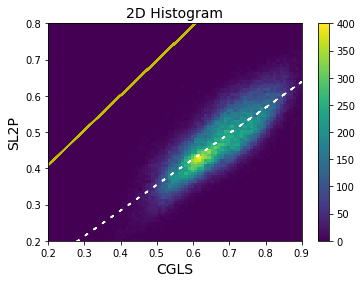

In [26]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'boreal', 0.1, 0.9,0.2,0.9, 0.2,0.8) 

in FAPAR CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.9089951882781919, 0.24179470822265714, 0.9035487366135817, 0.9144421131535956)
linear least-squares estimator: LinregressResult(slope=0.6771404219477455, intercept=0.06143306545969307, rvalue=0.7922865805894944, pvalue=0.0, stderr=0.00233214810810285)


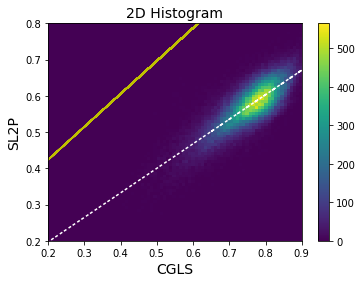

In [27]:
calStas2('FAPAR','CGLS', "D:\\vegetation\\gee\\FAPAR_CCRS", 'tropical', 0.1, 0.9,0.2,0.9, 0.2,0.8) 

in FCOVER CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (1.1995361924380101, 0.06304891954990388, 1.1949423562704804, 1.204135897927499)
linear least-squares estimator: LinregressResult(slope=0.652755406708595, intercept=0.06090078256645681, rvalue=0.8769001244291666, pvalue=0.0, stderr=0.001600196876842632)


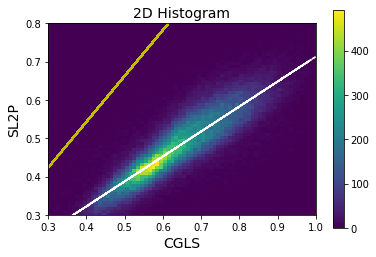

In [28]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_CCRS", 'boreal', 0.1, 0.9,  0.3,1, 0.3,0.8) 

in FCOVER CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.7179040751913298, 0.42565704151751216, 0.713182332615492, 0.7226222213833071)
linear least-squares estimator: LinregressResult(slope=0.8112914708474924, intercept=-0.06198286299657729, rvalue=0.7806960287974594, pvalue=0.0, stderr=0.002904268517048098)


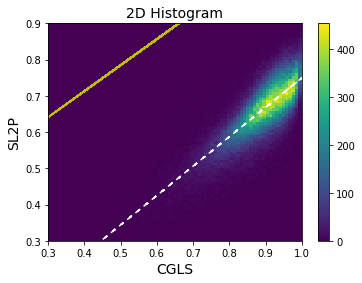

In [29]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_CCRS", 'temperate', 0.1, 0.9, 0.3,1, 0.3,0.9) 

in FCOVER CGLS
The number of csv files: 28
Sample points for plotting: 50000
Theil-Sen estimator: (0.893079398414141, 0.29646520460876125, 0.8860165645954008, 0.9001393505952048)
linear least-squares estimator: LinregressResult(slope=0.5489061672711197, intercept=0.13146581999450968, rvalue=0.6996692440339489, pvalue=0.0, stderr=0.0025067505743018464)


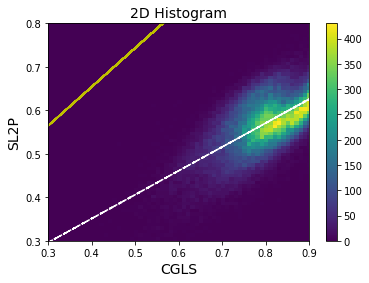

In [30]:
calStas2('FCOVER','CGLS', "D:\\vegetation\\gee\\FCOVER_CCRS", 'tropical', 0.1, 0.9, 0.3,0.9, 0.3,0.8) 